In [1]:
import pandas as pd
from collections import Counter
from langdetect import detect
import langdetect
import numpy as np
import importlib
import os
current_dir = os.getcwd()
%cd ..
import textmining.text_miner 
import textmining.loader  as loader
import textmining.topic_modeler as tm
import textmining.significance_testing as significance_testing
import textmining.utility as utility
import textmining.analysis as analysis
import textmining.cluster_analysis as cluster_analysis
import textmining.machine_learning as machine_learning
import textmining.news_editorials_experiments as experiment
import textmining.cross_models_significance as cross
importlib.reload(textmining.significance_testing)

importlib.reload(textmining.analysis)
importlib.reload(textmining.machine_learning)
importlib.reload(textmining.news_editorials_experiments)
importlib.reload(textmining.cross_models_significance)
importlib.reload(textmining.cluster_analysis)
importlib.reload(textmining.text_miner)

importlib.reload(textmining.text_miner)
importlib.reload(textmining.topic_modeler)
importlib.reload(textmining.analysis)
importlib.reload(textmining.analysis)

importlib.reload(textmining.loader)
os.chdir(current_dir)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

C:\Users\elba_ro\Documents\projects\nlpcss2020-editorials-analysis


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elba_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elba_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elba_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Get topi group for editorials

In [2]:
def get_editorial_topic_w_group():
    editorials_topics_df = pd.read_csv('../out/editorials_topic_w_group.csv').set_index('idx')
    return editorials_topics_df


In [5]:
editorials_topics_df = get_editorial_topic_w_group()
editorials_topics_df.head()

,topic_group,dominant_topic
idx,,
1851784,state,11.0
1845399,state,16.0
1677322,state,12.0
1818732,state,11.0
1844646,national,2.0


In [4]:
print('Topic Groups:', editorials_topics_df.topic_group.unique(), )

print('Topic #:', len(editorials_topics_df.dominant_topic.unique()))

editorials_topics_df.topic_group.value_counts()

Topic Groups: ['state' 'national' 'global']
Topic #: 18


national    475
state       277
global      227
Name: topic_group, dtype: int64

In [5]:
editorials_topics_df.head()

,topic_group,dominant_topic
idx,,
1851784,state,11.0
1845399,state,16.0
1677322,state,12.0
1818732,state,11.0
1844646,national,2.0


In [6]:
# Which features do we want LIWC and NR

In [6]:
def get_data_topic(path):
    data = pd.read_csv(path)#'../data/personality_all_features.csv')
    data.set_index('idx', inplace=True)
    
    data = data.join(get_editorial_topic_w_group(), how='inner')
    return data


In [7]:
def filter_training_features_out(data, profile, feature_types):
    training_df, _ = analysis.get_train_test(data)
    cols_map = experiment.get_features_map(training_df)
    cols= []
    for f in feature_types:
        cols.extend(cols_map[f])
    #print(cols)
    cols = cols + [profile, 'topic_group']

    df = training_df[cols].copy()
    
    return df
    
    

In [8]:
from pathlib import Path
def analyze_sign(df_orig, profile, p_value_threshold = 0.05,info='', save=False):
    
    groups = df_orig.topic_group.unique().tolist() + ['all']
    results = []
    print('first_rn')
    features = []
    for g in groups:

        if g is not 'all':
            df = df_orig.copy()
            df = df[df['topic_group'] == g]

        numeric_features_list = list(df.select_dtypes(include=[np.number]))


        sign_df = significance_testing.significance(df, features = numeric_features_list, 
                                           save = True, desc='../out/significance/{}_{}_train_{}'.format(
                                           g, profile, info), 
                                           independent_var=profile,
                                           p_value_threshold = p_value_threshold)
        features.extend(sign_df.reset_index()['feature'].values.tolist())


    features = list(set(features)) 
    print(features)
    
    for g in groups:
        result = {}
        result['group'] = g
        result['profile'] = profile


        print("Analyzing ",  g, 'for ', profile)

        if g is not 'all':
            df = df_orig.copy()
            df = df[df['topic_group'] == g]

        numeric_features_list = list(df.select_dtypes(include=[np.number]))


        significance_df = significance_testing.significance(df, features = numeric_features_list, 
                                           save = True, desc='../out/significance/{}_{}_train_{}'.format(
                                           g, profile, info), 
                                           independent_var=profile,
                                           p_value_threshold = p_value_threshold,
                                                                  keep_nan=True)
        significance_df.reset_index(inplace=True)
        significance_df = significance_df[significance_df['feature'].isin(features)]
        significance_df.set_index('feature', inplace=True)
        result['significance']  = significance_df

        Path('../out/heatmaps/intensity_final').mkdir(parents=True, exist_ok=True)

        result['effect'] = analysis.get_sign_features_hm(significance_df, threshold= 0, drop_na=False)
        analysis.plot_hm(result['effect'],  
                         filename='personality_group_final/heatmap_{}_{}_train_{}.pdf'.format(
                                           g, 'other', info) )
        results.append(result)
    return pd.DataFrame(results)

In [10]:
feature_types = ['liwc', 'nrc', 'adu', 'mpqa_arg', 'mpqa_subjobg']

# Extreme

In [11]:
extreme = filter_training_features_out(get_data_topic('../data/intensity_all_features.csv'),
                                 'extreme_majority', feature_types)

len(extreme)

783

In [38]:
pd.read_json('../data/pars_features.json').columns.values

array(['paragraph-id', 'communication_recommendation', 'conservative',
       'content', 'emotional_analysis_emotional_tone_rating',
       'emotional_analysis_emotional_tone_score',
       'emotional_analysis_facets_anger',
       'emotional_analysis_facets_fear', 'emotional_analysis_facets_sad',
       'headline', 'id', 'index', 'is-last', 'is-lead', 'liberal',
       'liwc_scores_analytic', 'liwc_scores_authentic',
       'liwc_scores_categories_AllPunc', 'liwc_scores_categories_Apostro',
       'liwc_scores_categories_Colon', 'liwc_scores_categories_Comma',
       'liwc_scores_categories_Dash', 'liwc_scores_categories_Exclam',
       'liwc_scores_categories_OtherP', 'liwc_scores_categories_Parenth',
       'liwc_scores_categories_Period', 'liwc_scores_categories_QMark',
       'liwc_scores_categories_Quote', 'liwc_scores_categories_SemiC',
       'liwc_scores_categories_achieve', 'liwc_scores_categories_adj',
       'liwc_scores_categories_adverb', 'liwc_scores_categories_affect',


In [30]:
intens_df= pd.read_csv('../data/intensity_all_features.csv')
#intens_df[intens_df['idx'] == 1787348][['content']].values.tolist()

#1801137
intens_df[intens_df['idx'] == 1801137][['content']].values.tolist()

[["The Supreme Court has been struggling to address the thorny question of when, if ever, punitive damages become so large that they violate the Constitution. The court made a good start when it laid down guidelines on when punitive damages are excessive. But eventually, it went too far. Today, it hears arguments in a case that offers a perfect opportunity to pull back to a more reasonable position.\n        The case involves Philip Morris's challenge to damages awarded to the widow of a smoker who died of lung cancer. An Oregon jury awarded Jesse Williams's widow, Mayola Williams, more than $821,000 in actual damages, and $79.5 million in punitive damages. Mrs. Williams said Philip Morris had engaged in 40 years of publicity to undercut concerns about cigarettes, even though it knew for most or all of that time that smoking was deadly.\n        The Oregon Supreme Court upheld the punitive damages award. The court said the conduct that Philip Morris was charged with ''would have kept m

In [22]:
extreme[(extreme['topic_group'] == 'state') & (extreme['extreme_majority'] == 'challenging')][['nrc_ratio']]

,nrc_ratio
idx,
1677322,0.33962
1785853,0.49520
1825399,0.38045
1764885,0.42458
1698569,0.41723
1823692,0.44110
1818847,0.37915
1818687,0.39535
1792266,0.39104


In [12]:
pd.crosstab(extreme['topic_group'], extreme['extreme_majority'] )


extreme_majority,challenging,no_effect,reinforcing
topic_group,,,
global,37,35,126
national,79,56,229
state,40,42,139


first_rn
data has 221 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
exception for feature  invalid value encountered in greater
data has 198 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
mpqa_arg_rhetoricalquestion
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  invalid value encountered in greater
data has 364 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
liwc_scores_categori

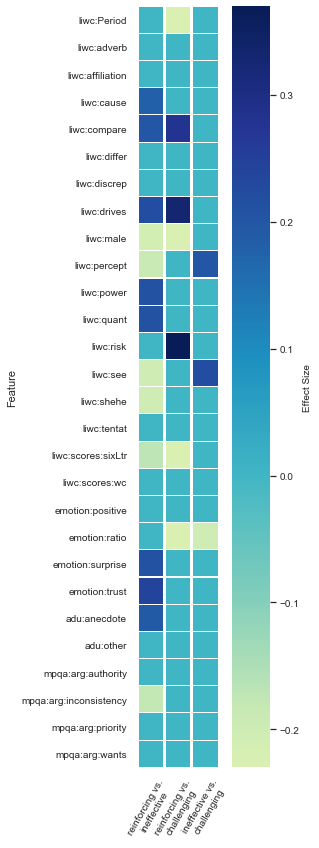

Analyzing  global for  extreme_majority
data has 198 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
mpqa_arg_rhetoricalquestion
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  invalid value encountered in greater


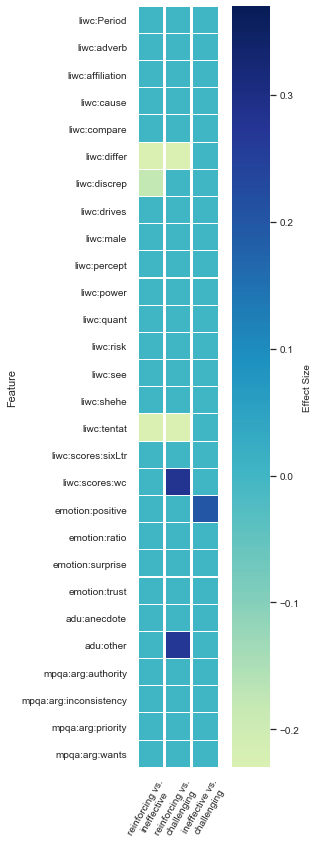

Analyzing  national for  extreme_majority
data has 364 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
liwc_scores_categories_Quote
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal


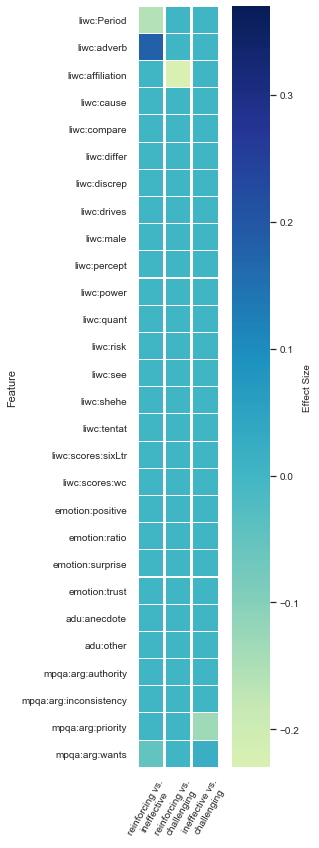

Analyzing  all for  extreme_majority
data has 364 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
liwc_scores_categories_Quote
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal


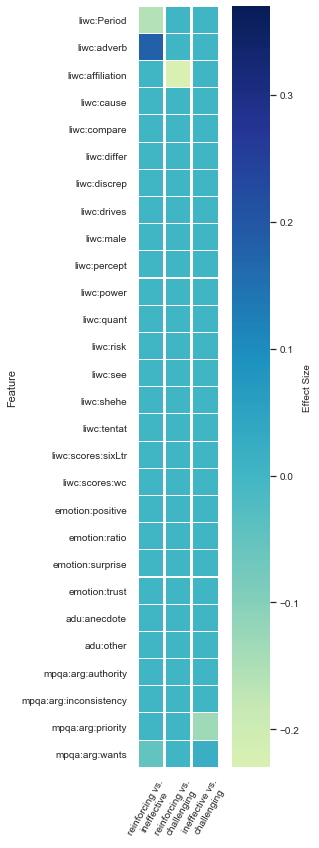

In [13]:
extreme_es=analyze_sign(extreme, 'extreme_majority')

# Personality

In [26]:
personality = filter_training_features_out(get_data_topic('../data/personality_all_features.csv'),
                                 'personality_a_majority', feature_types)

len(personality)
personality

,liwc_scores_analytic,liwc_scores_authentic,liwc_scores_categories_AllPunc,liwc_scores_categories_Apostro,liwc_scores_categories_Colon,liwc_scores_categories_Comma,liwc_scores_categories_Dash,liwc_scores_categories_Exclam,liwc_scores_categories_OtherP,liwc_scores_categories_Parenth,...,mpqa_arg_necessity,mpqa_arg_possibility,mpqa_arg_priority,mpqa_arg_rhetoricalquestion,mpqa_arg_structure,mpqa_arg_wants,mpqa_subjobg_obj,mpqa_subjobg_subj,personality_a_majority,topic_group
idx,,,,,,,,,,,,,,,,,,,,,
1677322,96.31808,7.406872,0.187891,0.029228,0.002088,0.048017,0.033403,0.0,0.008351,0.004175,...,2,0,2,0,0,0,14,8.0,challenging,state
1818732,94.43507,34.668915,0.134091,0.009091,0.000000,0.061364,0.022727,0.0,0.004545,0.004545,...,1,0,0,0,0,0,9,6.0,no_effect,state
1680635,95.17905,7.772578,0.150538,0.023656,0.000000,0.053763,0.021505,0.0,0.000000,0.000000,...,2,1,1,0,0,0,3,10.0,no_effect,global
1647477,94.34641,10.007819,0.160410,0.022184,0.001706,0.037543,0.025597,0.0,0.005119,0.000000,...,1,0,1,0,1,0,8,12.0,no_effect,global
1785853,83.92002,15.706834,0.100379,0.001894,0.000000,0.028409,0.022727,0.0,0.000000,0.000000,...,3,0,2,0,0,0,15,11.0,challenging,state
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693956,97.56162,38.093925,0.143885,0.021583,0.002398,0.035971,0.033573,0.0,0.002398,0.000000,...,3,0,0,0,0,0,11,10.0,no_effect,global
1652153,96.06809,15.629082,0.128736,0.006897,0.000000,0.057471,0.018391,0.0,0.000000,0.000000,...,4,0,0,0,0,0,8,11.0,no_effect,global
1806988,94.14228,32.985050,0.123188,0.016908,0.000000,0.045894,0.007246,0.0,0.000000,0.000000,...,0,3,1,0,0,0,12,6.0,challenging,national


In [31]:
personality[(personality['topic_group'] == 'national') & (personality['personality_a_majority'] == 'reinforcing')& (personality['nrc_fear'] > 20)]

,liwc_scores_analytic,liwc_scores_authentic,liwc_scores_categories_AllPunc,liwc_scores_categories_Apostro,liwc_scores_categories_Colon,liwc_scores_categories_Comma,liwc_scores_categories_Dash,liwc_scores_categories_Exclam,liwc_scores_categories_OtherP,liwc_scores_categories_Parenth,...,mpqa_arg_necessity,mpqa_arg_possibility,mpqa_arg_priority,mpqa_arg_rhetoricalquestion,mpqa_arg_structure,mpqa_arg_wants,mpqa_subjobg_obj,mpqa_subjobg_subj,personality_a_majority,topic_group
idx,,,,,,,,,,,,,,,,,,,,,
1796959,98.103836,4.303494,0.114504,0.007634,0.000000,0.030534,0.012723,0.0,0.000000,0.0,...,2,0,0,0,0,0,12,6.0,reinforcing,national
1713893,98.618034,14.578360,0.144470,0.029345,0.000000,0.040632,0.033860,0.0,0.000000,0.0,...,0,0,2,0,0,0,7,10.0,reinforcing,national
1656067,90.121260,16.105402,0.152364,0.033275,0.000000,0.052539,0.007005,0.0,0.000000,0.0,...,1,0,0,0,1,0,21,8.0,reinforcing,national
1823663,88.499120,13.985974,0.133641,0.018433,0.002304,0.057604,0.009217,0.0,0.000000,0.0,...,2,1,0,0,1,0,13,6.0,reinforcing,national
1651054,89.953510,7.564492,0.138632,0.033272,0.001848,0.038817,0.007394,0.0,0.001848,0.0,...,2,0,1,0,0,0,16,10.0,reinforcing,national
1642127,84.736150,17.059755,0.101933,0.008787,0.000000,0.033392,0.012302,0.0,0.000000,0.0,...,1,0,0,0,1,0,10,14.0,reinforcing,national
1801137,84.318726,21.199465,0.176972,0.049041,0.000000,0.059701,0.006397,0.0,0.012793,0.0,...,2,0,0,0,0,0,9,14.0,reinforcing,national
1827751,92.100680,10.224227,0.192214,0.072993,0.000000,0.038929,0.024331,0.0,0.009732,0.0,...,1,0,0,0,0,0,7,12.0,reinforcing,national
1647258,94.070810,2.620798,0.170874,0.060194,0.001942,0.031068,0.009709,0.0,0.000000,0.0,...,2,0,1,0,1,0,13,12.0,reinforcing,national


In [17]:
pd.crosstab(personality['topic_group'], personality['personality_a_majority'] )
#pd.crosstab(personality['topic_group'], personality['personality_b_majority'] )

personality_a_majority,challenging,no_effect,reinforcing
topic_group,,,
global,23,118,57
national,53,176,135
state,30,118,73


first_rn
data has 221 instances
bonforrini_threshold:  0.016666666666666666
exception for feature  All numbers are identical in kruskal
mpqa_arg_doubt
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
data has 198 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal
data has 364 instances
bonforrini_threshold:  0.016666666666666666
exception for feature  All numbers are identical in kruskal
data has 364 instances
bonforrini_threshold:  0.016666666666666666
exception for feature  All numbers are identical in kruskal
['liwc_scores_dic', 'liwc_scores_categories_adverb', 'liwc_scores_categories_death', 'mpqa_arg_emphasis', 'liwc_scores_categories_QMark', 'liw

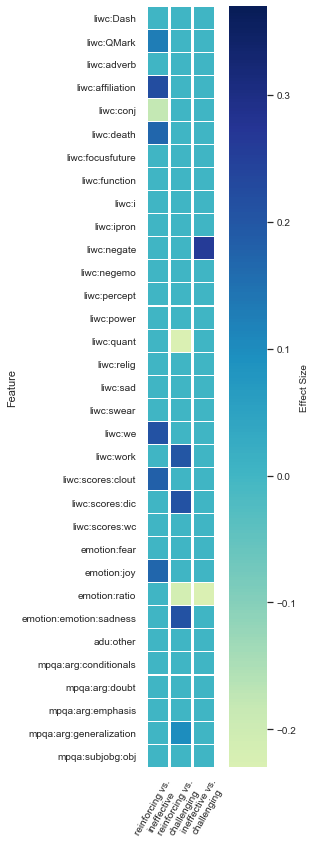

Analyzing  global for  personality_a_majority
data has 198 instances
bonforrini_threshold:  0.016666666666666666
liwc_scores_categories_Exclam
INNER EXCEPTION All numbers are identical in mannwhitneyu
exception for feature  All numbers are identical in kruskal
exception for feature  All numbers are identical in kruskal


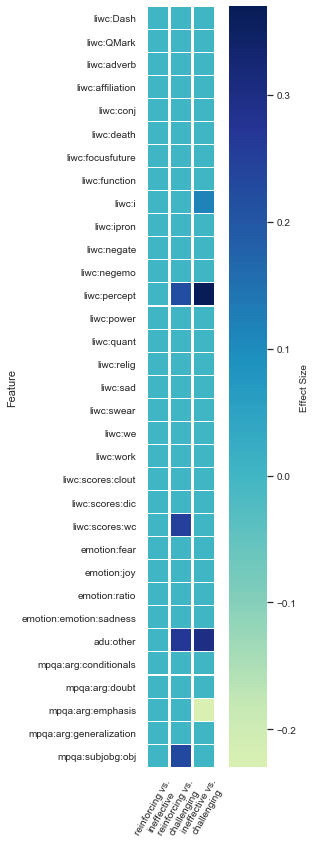

Analyzing  national for  personality_a_majority
data has 364 instances
bonforrini_threshold:  0.016666666666666666
exception for feature  All numbers are identical in kruskal


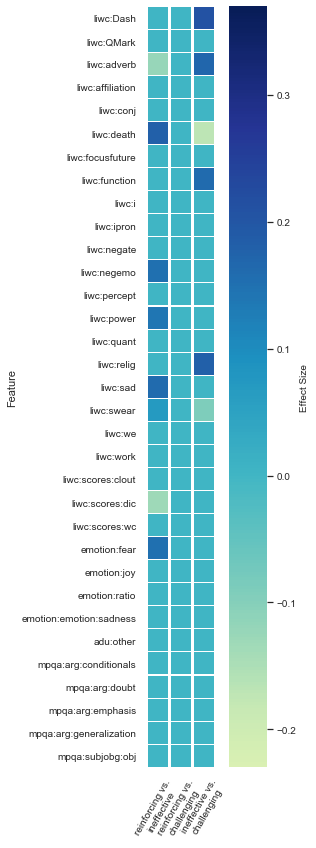

Analyzing  all for  personality_a_majority
data has 364 instances
bonforrini_threshold:  0.016666666666666666
exception for feature  All numbers are identical in kruskal


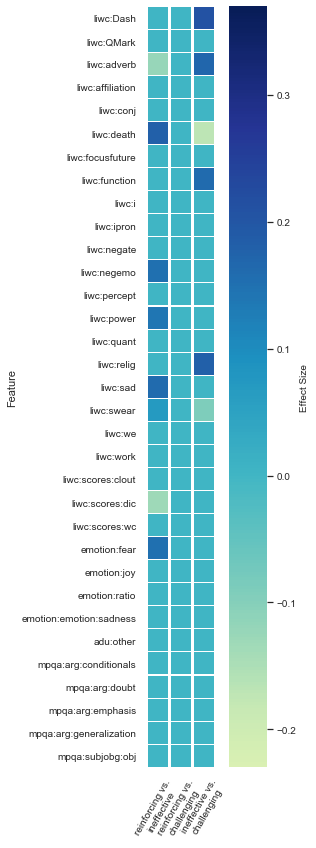

In [18]:
es=analyze_sign(personality, 'personality_a_majority')

In [ ]:
es

In [ ]:
for i, row in es.iterrows():
    sig = row['significance']
    for col in sig.columns.values:
        print(sig[col].max())

In [ ]:
len(data.columns.values)

In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,7)}, 
    #style="white" # nicer layout
)
import seaborn as sns
import textwrap

max_width = 17
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
sns.set(style="whitegrid")


df = pd.DataFrame(es).iloc[3]['effect']

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create s

data = df


# sns.s
#ac = pyplot.subplots(figsize=(10, 5))
ax = sns.heatmap(df, center=0, cmap="YlGnBu", xticklabels=True, yticklabels=True,
                 linewidths=0.05, square=True, cbar_kws={'label': 'Effect Size'})
#  ax.set_xticklabels(labels=["Chall. vs. No-Eff.", "Reinf. vs. No-Eff.", "Reinf. vs. Chall."],rotation=45,
#                     ha="right", fontdict={'fontsize':8
#                                          })

# ax.set_ymargin(0)
# ax.get_figure().save_fig("liberal_discourse.png")
ax.set_ylabel("Feature", fontsize=11
             )

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.figure.axes[-1].yaxis.label.set_size(10)

x_axis = ['reinforcing vs. ineffective', 
          'reinforcing vs. challenging', 
          'ineffective vs. challenging']
#ax.set_xticklabels(x_axis, rotation=45, ha="right", fontsize=7)

ax.set_xticklabels([textwrap.fill(x, max_width) for x in x_axis],
                   rotation=60, horizontalalignment="center", fontsize=10)

for i in range(len(data.columns.values)):
    ax.axvline(i, color='white', lw=3)
#plt.xticks(x_axis, [textwrap.fill(label, 10) for label in labels], 
#           rotation = 10, fontsize=8, horizontalalignment="center")

cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=10)


plt.show()

In [ ]:
ome random data
data = df

# get the tick label font size
fontsize_pt = plt.rcParams['ytick.labelsize']
dpi = 72.27

# comput the matrix height in points and inches
matrix_height_pt = fontsize_pt * len(data)
matrix_height_in = matrix_height_pt / dpi

# compute the required figure height 
top_margin = 0.04  # in percentage of the figure height
bottom_margin = 0.04 # in percentage of the figure height
figure_height = matrix_height_in / (1 - top_margin - bottom_margin)


# build the figure instance with the desired height
fig, ax = plt.subplots(
        figsize=(6,figure_height), 
        gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin))
